In [1]:
from os import system as bash
from pyspark.sql import SparkSession
from splicemachine.spark import PySpliceContext
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pyspark.sql.types import TimestampType
from datetime import datetime
import seaborn as sns
from sklearn.cluster import DBSCAN
import pandas as pd
import numpy as np
import time
import random

/opt/conda/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext
splice = PySpliceContext(spark)

In [3]:
usa_ports = {}
with open('USAPortNameWithLocDf.csv') as reader:
    for i, line in enumerate(reader):
        if i > 0:
            original_line = line
            
            line = line[:-1].split(',')
            long = float(line[-1][:-1])
            lat = float(line[-2][:-1])
            
            if line[-1][-1] == 'W':
                long_sign = -1
            else:
                long_sign = 1
            if line[-2][-1] == 'N':
                lat_sign = 1
            else:
                lat_sign = -1

            portname = line[0][2:]
            usa_ports[portname] = np.array([lat*lat_sign, long*long_sign])

In [4]:
SCHEMA = 'AGUPTA'
TABLE = 'januarysmall'

In [5]:
#if you want to find list of mmsi
'''df = splice.df("select MMSI from "  + SCHEMA + '.' + TABLE )
unique = df.distinct()
unique_mmsi = unique.toPandas()
unique_mmsi.to_pickle('Processed_Data/' + TABLE +  '_mmsi_freq.pkl')'''

In [21]:
d = pd.read_pickle('Processed_Data/mmsi_freq.pkl')
mmsi_above_20k = d[d['c1'] > 20000]['c0']
unique_mmsi  = list(mmsi_above_20k)
unique_mmsi =  [int(mmsi) for mmsi in unique_mmsi]
random.shuffle(unique_mmsi)

In [27]:
port_loc = list(usa_ports.values())
start = time.time()

#initialize done_mmsi, valid_mmsi
try:
    done_mmsi = np.load('done_mmsi.npy')
except:
    done_mmsi = np.array([])

try:
    valid_mmsi = np.load('valid_mmsi.npy')
except:
    valid_mmsi = np.array([])
    
    
    
for mmsi in unique_mmsi:
    print(mmsi)
    
    if mmsi in done_mmsi:
        continue
    
    #get data from database
    query = 'select BaseDateTime, Lon, Lat from ' + SCHEMA + '.' + TABLE + ' where MMSI = ' + str(mmsi)
    df = splice.df(query)
    
    #convert to pandas, sort according to date times
    trajectory = df.toPandas()
    trajectory = trajectory.sort_values(by=['BASEDATETIME'])
    print('Number of trajectory points:', len(trajectory))
    if len(trajectory) == 0:
        continue
     
    #creating latitudes and longitudes
    latitude = list(trajectory['LAT'])
    longitude = list(trajectory['LON'])
    traj = []
    for (lat, long) in zip(latitude, longitude):
        traj.append([float(lat), float(long)])
    traj = np.array(traj)

    #finding viable ports and plot
    min_distances = []
    distance_limit = 0.01
    valid_ports = 0
    plt.plot(traj[:,0], traj[:,1])
    for port in port_loc:
        d = np.linalg.norm(port - traj, axis = 1)

        if np.min(d) < distance_limit:
            min_distances.append(np.min(d))
            valid_ports += 1
            plt.plot(port[0], port[1], 'r*')

    print('Number of valid ports:', valid_ports, min_distances)
    plt.title('Number of valid ports: ' + str(valid_ports))
    if valid_ports > 0:
        plt.savefig('Plots/' + str(mmsi) + '.png')
        plt.close()
        
        plt.plot(traj[:,0])
        plt.savefig('Plots/' + str(mmsi) + 'lat' + '.png')
        plt.close()
        
        plt.plot(traj[:,1])
        plt.savefig('Plots/' + str(mmsi) + 'long' + '.png')
        plt.close()
        
        valid_mmsi = np.array(list(valid_mmsi) + [mmsi])
        np.save('valid_mmsi.npy', valid_mmsi)
        
        print('Movement quotient:', np.max(traj[:,0]) - np.min(traj[:,0]), np.max(traj[:,1]) - np.min(traj[:,1]))
    else:
        for port in port_loc:
            plt.plot(port[0], port[1], 'r*')
        plt.savefig('Plots/NoValid/' + str(mmsi) + '.png')
        plt.close()
    
    #Finishing up
    done_mmsi = np.array(list(done_mmsi) + [mmsi])
    np.save('done_mmsi.npy', done_mmsi)
    print('Length of done mmsi:', done_mmsi.shape)
    print('Time:', time.time() - start)
    start = time.time()
    print('='*20)
    print()

367685720
316008255
367057610
366996380
366880470
367642530
366909730
366823870
367456560
Number of trajectory points: 35030
Number of valid ports: 0 []
Length of done mmsi: (9,)
Time: 113.90972018241882

367013470
Number of trajectory points: 14601
Number of valid ports: 0 []
Length of done mmsi: (10,)
Time: 84.4737195968628

367520270
Number of trajectory points: 37944
Number of valid ports: 0 []
Length of done mmsi: (11,)
Time: 84.98270058631897

367791550
Number of trajectory points: 27683
Number of valid ports: 1 [0.0042638128476829565]
Movement quotient: 0.24177999999999855 0.21286999999999523
Length of done mmsi: (12,)
Time: 82.0047345161438

367704430
Number of trajectory points: 12741
Number of valid ports: 0 []
Length of done mmsi: (13,)
Time: 83.14506840705872

367720970
Number of trajectory points: 36549
Number of valid ports: 0 []
Length of done mmsi: (14,)
Time: 84.82793879508972

367534680
Number of trajectory points: 36053
Number of valid ports: 0 []
Length of done mmsi

Length of done mmsi: (55,)
Time: 83.7004919052124

366989120
Number of trajectory points: 35247
Number of valid ports: 0 []
Length of done mmsi: (56,)
Time: 84.56228351593018

367529160
Number of trajectory points: 14787
Number of valid ports: 0 []
Length of done mmsi: (57,)
Time: 85.10481357574463

316001649
Number of trajectory points: 31899
Number of valid ports: 0 []
Length of done mmsi: (58,)
Time: 83.14809393882751

367514360
Number of trajectory points: 21576
Number of valid ports: 2 [0.0006987131027800848, 0.0008700000000046736]
Movement quotient: 0.5033699999999968 0.8239799999999917
Length of done mmsi: (59,)
Time: 83.58446645736694

367122610
Number of trajectory points: 0
367375080
Number of trajectory points: 24707
Number of valid ports: 0 []
Length of done mmsi: (60,)
Time: 163.85463166236877

367702340
Number of trajectory points: 37603
Number of valid ports: 5 [0.0013524792050128161, 0.002448040032359189, 0.0064573833709941145, 0.00483993801613384, 0.003457744929861091]

Number of valid ports: 0 []
Length of done mmsi: (98,)
Time: 82.93092155456543

367047240
Number of trajectory points: 30752
Number of valid ports: 3 [0.004730803314445104, 0.0012114866899808024, 0.0035027560577408578]
Movement quotient: 0.7700400000000016 1.4869599999999963
Length of done mmsi: (99,)
Time: 83.25655150413513

367494020
Number of trajectory points: 36549
Number of valid ports: 1 [0.005862849136728874]
Movement quotient: 0.0002999999999957481 0.00027999999998939984
Length of done mmsi: (100,)
Time: 84.12587261199951

367186840
Number of trajectory points: 35309
Number of valid ports: 2 [0.004695210325424592, 0.009971208552627208]
Movement quotient: 0.15387000000000128 0.7784500000000065
Length of done mmsi: (101,)
Time: 82.97275471687317

367093960
Number of trajectory points: 34627
Number of valid ports: 0 []
Length of done mmsi: (102,)
Time: 81.12993812561035

366999840
Number of trajectory points: 36952
Number of valid ports: 0 []
Length of done mmsi: (103,)
Time: 80.

Number of valid ports: 1 [0.008531096060878231]
Movement quotient: 0.00035000000000096065 0.0002800000000036107
Length of done mmsi: (138,)
Time: 83.36346912384033

366936670
Number of trajectory points: 35743
Number of valid ports: 0 []
Length of done mmsi: (139,)
Time: 82.37402057647705

367328790
Number of trajectory points: 38068
Number of valid ports: 3 [0.0017189822570363262, 0.0013958868148926822, 0.0024100622398616016]
Movement quotient: 0.07723999999999975 0.14914000000000271
Length of done mmsi: (140,)
Time: 82.81262564659119

369578000
Number of trajectory points: 35836
Number of valid ports: 0 []
Length of done mmsi: (141,)
Time: 84.0200743675232

367606370
Number of trajectory points: 36363
Number of valid ports: 0 []
Length of done mmsi: (142,)
Time: 84.09322714805603

366760610
Number of trajectory points: 24087
Number of valid ports: 0 []
Length of done mmsi: (143,)
Time: 83.2888171672821

368053210
Number of trajectory points: 39184
Number of valid ports: 0 []
Length o

Number of valid ports: 6 [0.00032140317358759634, 0.00495552217228269, 0.0009121951545551597, 0.00023600847442797952, 0.00010440306507936815, 0.0013104579352188755]
Movement quotient: 0.7001400000000011 0.9294900000000013
Length of done mmsi: (183,)
Time: 80.21970844268799

367719750
Number of trajectory points: 37355
Number of valid ports: 0 []
Length of done mmsi: (184,)
Time: 78.78737783432007

366951140
Number of trajectory points: 37479
Number of valid ports: 0 []
Length of done mmsi: (185,)
Time: 80.32072234153748

367379670
Number of trajectory points: 35991
Number of valid ports: 3 [0.0034014702703372246, 0.0007510659092214161, 0.0004301162633533591]
Movement quotient: 0.09705999999999904 0.29036000000000683
Length of done mmsi: (186,)
Time: 80.26667523384094

367339240
Number of trajectory points: 21700
Number of valid ports: 0 []
Length of done mmsi: (187,)
Time: 82.17302703857422

367708870
Number of trajectory points: 34875
Number of valid ports: 0 []
Length of done mmsi: (

KeyboardInterrupt: 

In [10]:
done_mmsi = np.array([636092782, 316009842, 209933000, 367390880, 367531730, 36759782, 367597820, 368063890, 367001510, 366972930, 338595000, 338181459])
np.save('done_mmsi.npy', done_mmsi)

In [11]:
done_mmsi = np.load('done_mmsi.npy')
print(done_mmsi)

[636092782 316009842 209933000 367390880 367531730  36759782 367597820
 368063890 367001510 366972930 338595000 338181459]


In [16]:
np.array(list(done_mmsi) + [338181459])

array([636092782, 316009842, 209933000, 367390880, 367531730,  36759782,
       367597820, 368063890, 367001510, 366972930, 338595000, 338181459,
       338181459])

In [17]:
port_loc = list(usa_ports.values())

In [ ]:
#finding viable ports
min_distances = []
distance_limit = 1
valid_ports = 0
plt.plot(traj[:,0], traj[:,1])
for port in port_loc:
    d = np.linalg.norm(port - traj, axis = 1)
    min_distances.append(np.min(d))
    if np.min(d) < distance_limit:
        valid_ports += 1
        plt.plot(port[0], port[1], 'r*')

print(valid_ports)

Number of valid ports: 0


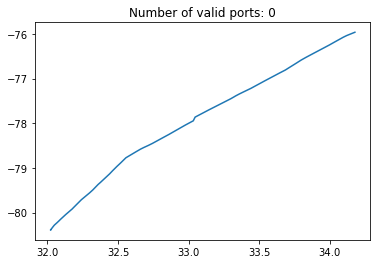

In [44]:
#finding viable ports and plot
min_distances = []
distance_limit = 0.1
valid_ports = 0
plt.plot(traj[:,0], traj[:,1])
for port in port_loc:
    d = np.linalg.norm(port - traj, axis = 1)
    min_distances.append(np.min(d))
    
    if np.min(d) < distance_limit:
        valid_ports += 1
        plt.plot(port[0], port[1], 'r*')

print('Number of valid ports:', valid_ports)
plt.title('Number of valid ports: ' + str(valid_ports))
plt.savefig('Plots/' + str(mmsi) + '.png')

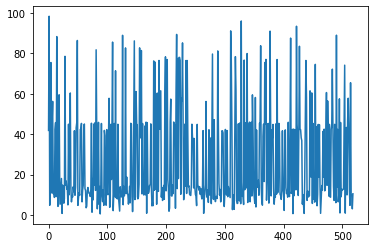

In [37]:
plt.plot(min_distances)

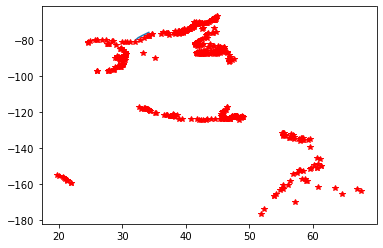

In [29]:
plt.plot(traj[:,0], traj[:,1])
for port in port_loc:
    plt.plot(port[0], port[1], 'r*')

In [118]:
latitude = list(trajectory['LAT'])
longitude = list(trajectory['LON'])
traj = []
for (lat, long) in zip(latitude, longitude):
    traj.append([float(lat), float(long)])
traj = np.array(traj)
    
latitude = [float(lat) for lat in latitude]
longitude = [float(long) for long in longitude]
print(max(latitude), min(latitude))
print(max(longitude), min(longitude))

29.95952 28.22498
-87.77792 -90.23027


In [112]:
lat_sign = np.sign(latitude[0])
long_sign = np.sign(longitude[0])
ports = []
for port in mmsi_port_loc[mmsi]:
    lat = port[0] * lat_sign
    long = port[1] * long_sign
    ports.append(np.array([lat, long]))

In [149]:
distances = []
distance_limit = 0.002
valid_ports = 0
for port in ports:
    d = np.linalg.norm(port - traj, axis = 1)
    if np.min(d) < distance_limit:
        valid_ports += 1

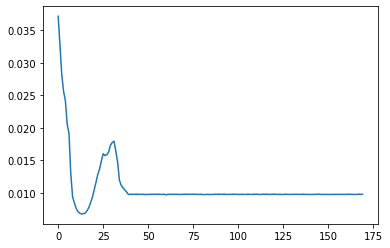

In [148]:
plt.plot(distances[1][14030:14200])

In [115]:
np.array([1,2]) - np.array([[1,2], [20,10]])

array([[  0,   0],
       [-19,  -8]])

In [108]:
port1 = np.array([lat1, long1])
port2 = np.array([lat2, long2])
distance1 = []
distance2 = []
distance_limit = 0.001
out_of_trajectory = 5
for (lat, long) in zip(latitude, longitude):
    d = np.linalg.norm(port1 - np.array([lat, long]))
    distance1.append(d)
    d = np.linalg.norm(port2 - np.array([lat, long]))
    distance2.append(d)

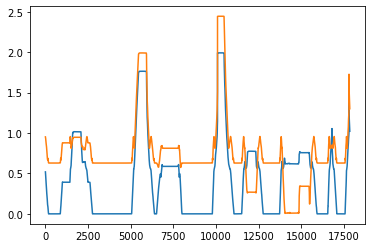

In [107]:
plt.plot(distance1)
plt.plot(distance2)

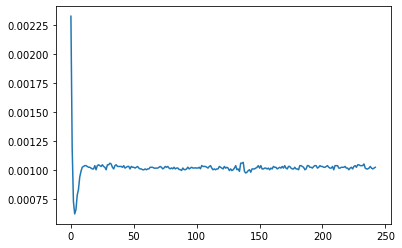

In [85]:
plt.plot(distance[2757:3000])

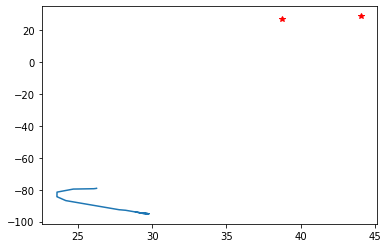

In [99]:
plt.plot(np.array(latitude), np.array(longitude))
plt.plot(lat1, -long1, 'r*')
plt.plot(lat2, -long2, 'r*')

In [41]:
 mmsi_port_loc[mmsi]

[(29.4741, 89.6838), (29.1294, 90.2115)]